# Group BackBenchers
    Shubham Agrawal C0911596
    Tanmay Sharma C0912911  
    Rahul Mehta C0910406
    Hardik C0913846 


In [9]:
#Importing libraries
#Basic libraries
import pandas as pd
import numpy as np
import string  
import warnings
warnings.filterwarnings("ignore") 

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import textstat

#Language models
from sentence_transformers import SentenceTransformer
import spacy
import transformers
import torch

#Grammar checker
import language_tool_python

#Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

#Set up NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
#Loading training data
train_data = pd.read_csv('train.csv')

In [13]:
#checking first 20 rows of the dataset
train_data.head(20)

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
5,0030e86,If I were to choose between keeping the electo...,4
6,0033037,The posibilty of a face reconizing computer wo...,2
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3
8,0036253,The challenge of exploring Venus\n\nThis stori...,2
9,0040e27,There are many reasons why you should join sea...,3


## EDA

In [16]:
#checking for any missing values
print("Training Missing Values:\n", train_data.isnull().sum())

Training Missing Values:
 essay_id     0
full_text    0
score        0
dtype: int64


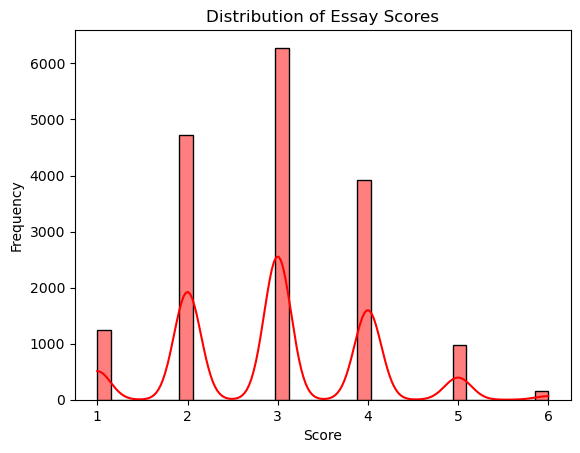

In [18]:
#analyzing the score distribution of essays
sns.histplot(train_data['score'], kde=True, color='red')
plt.title("Distribution of Essay Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

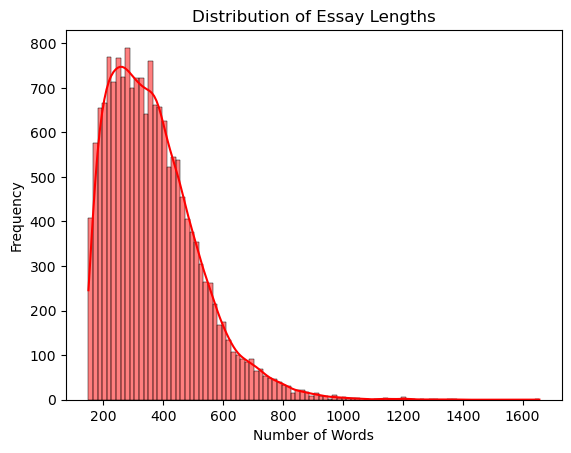

In [20]:
#analyzing essay lengths
train_data['essay_length'] = train_data['full_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['essay_length'], kde=True, color='red')
plt.title("Distribution of Essay Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## Data Pre-processing

In [23]:
#initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [25]:
#text cleaning function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())                           #tokenize and lowercase
    tokens = [word for word in tokens if word.isalnum()]            #removing special characters
    tokens = [word for word in tokens if word not in stop_words]    #removing the stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]       #lemmatization
    return ' '.join(tokens)


In [27]:
#extracting grammar related features from the text
def grammar_features(text):
    num_sentences = len(sent_tokenize(text))  #number of sentences
    words = word_tokenize(text)               #list of all words
    num_words = len(words)                    #total words
    punctuation_count = sum(1 for char in text if char in string.punctuation)    #punctuation count
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0  #avg sentence length
    punctuation_density = punctuation_count / num_words if num_words > 0 else 0  #punctuation density
    return {
        "num_sentences": num_sentences,
        "avg_sentence_length": avg_sentence_length,
        "punctuation_density": punctuation_density,
    }

In [29]:
#applying preprocessing function to the dataset
train_data['cleaned_text'] = train_data['full_text'].apply(preprocess_text)

In [30]:
#applying grammar surrogate feature extraction
grammar_data = train_data['full_text'].apply(grammar_features)
grammar_df = pd.DataFrame(grammar_data.tolist())

In [31]:
#adding grammar features to the dataset
train_data = pd.concat([train_data, grammar_df], axis=1)

In [32]:
#checking the cleaned and augmented dataset
train_data.head()

,essay_id,full_text,score,essay_length,cleaned_text,num_sentences,avg_sentence_length,punctuation_density
0,000d118,Many people have car where they live. The thin...,3,498,many people car live thing know use car alot t...,13,41.923077,0.075229
1,000fe60,I am a scientist at NASA that is discussing th...,3,332,scientist nasa discussing face mar explaining ...,21,17.666667,0.110512
2,001ab80,People always wish they had the same technolog...,4,550,people always wish technology seen movie best ...,24,25.208333,0.092562
3,001bdc0,"We all heard about Venus, the planet without a...",4,451,heard venus planet without almost oxygen earth...,20,25.550000,0.119374
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,373,dear state senator letter argue favor keeping ...,15,27.866667,0.112440


In [37]:
#creating column for checking vocabulary richness
train_data['vocab_richness'] = train_data['cleaned_text'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0  #ratio of unique words to total
)


In [39]:
#adding a new column 'readability' to the dataFrame, which calculates the Flesch Reading Ease score
train_data['readability'] = train_data['cleaned_text'].apply(textstat.flesch_reading_ease)


In [85]:
print(train_data.columns)


Index(['essay_id', 'full_text', 'score', 'essay_length', 'cleaned_text',
       'num_sentences', 'avg_sentence_length', 'punctuation_density',
       'vocab_richness', 'readability', 'sentence_embedding'],
      dtype='object')


## Visualization

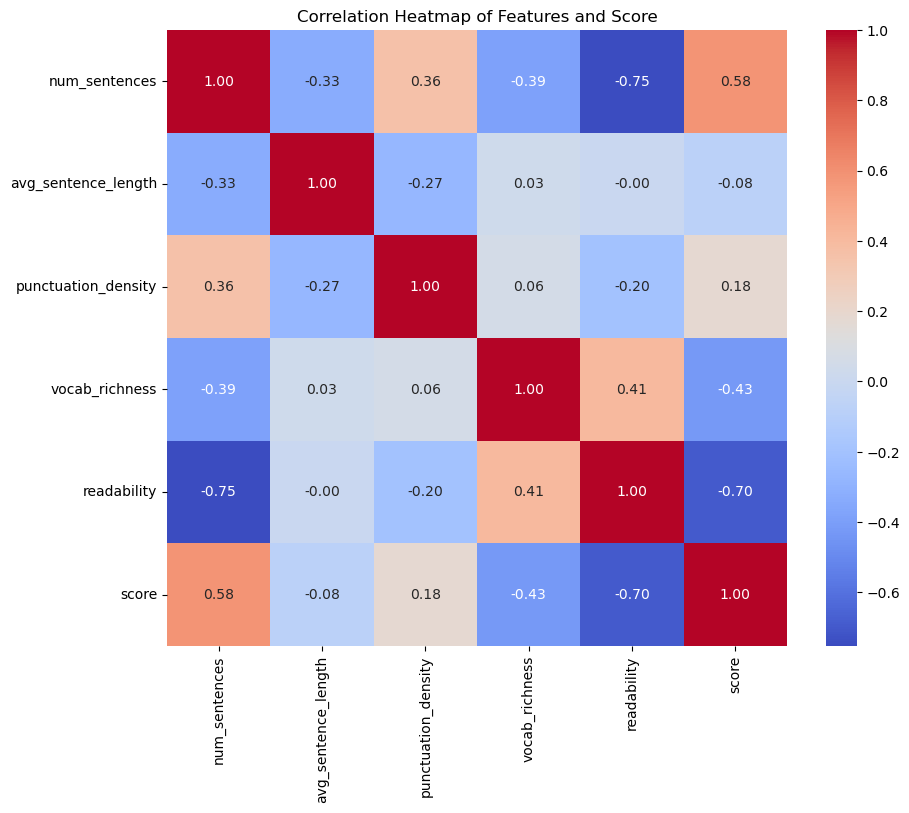

In [87]:
#relevant features and target for correlation analysis
eda_features = ['num_sentences', 'avg_sentence_length', 'punctuation_density', 'vocab_richness', 'readability', 'score']

#compute the correlation matrix
correlation_matrix = train_data[eda_features].corr()

#plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features and Score")
plt.show()


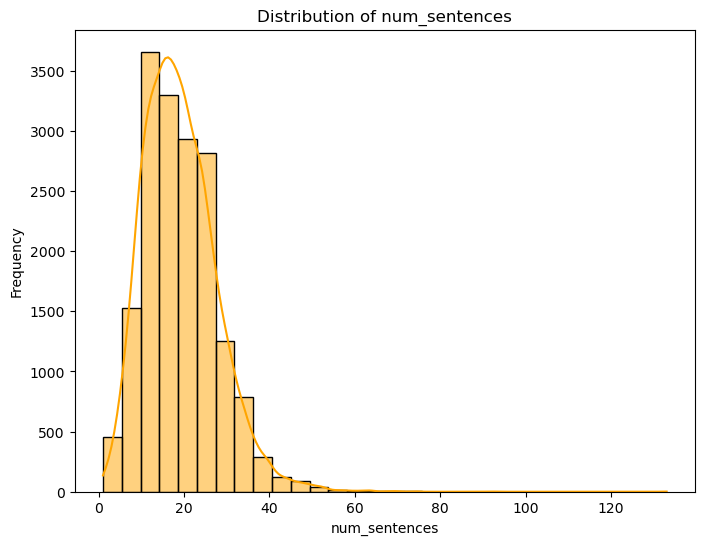

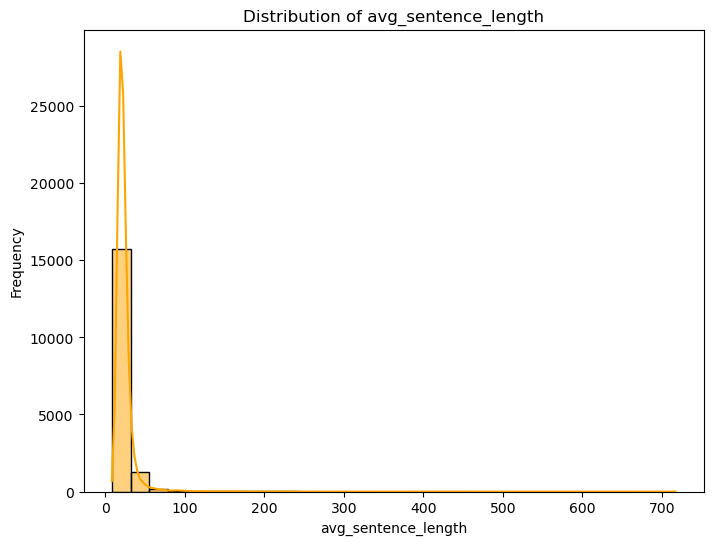

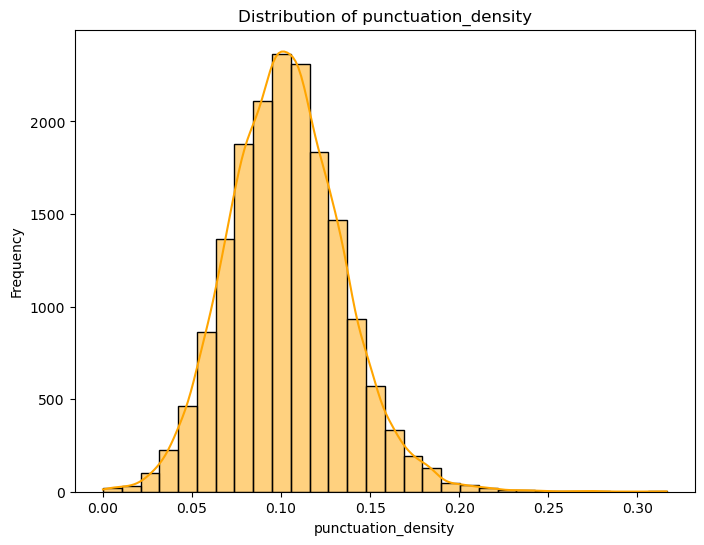

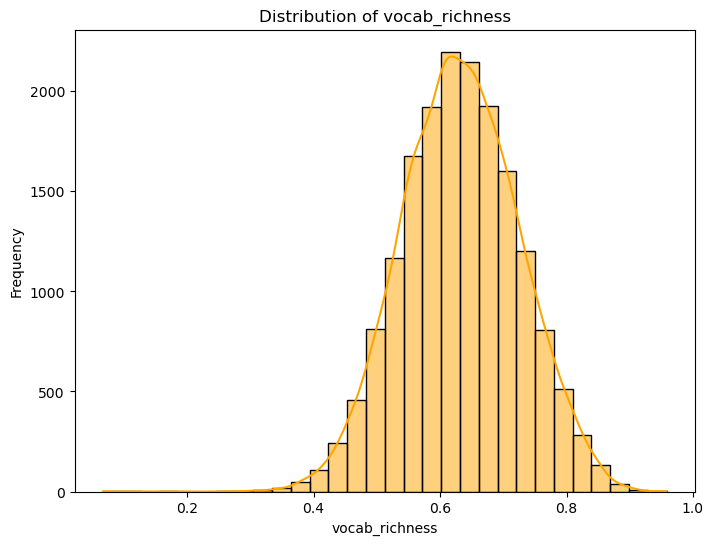

In [121]:
#plotting feature distributions
features_to_plot = ['num_sentences', 'avg_sentence_length', 'punctuation_density', 'vocab_richness']

for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_data[feature], kde=True, bins=30, color='red')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


## Data for modelling

In [18]:
#preparing data for modelling
features = ['num_sentences', 'avg_sentence_length', 'punctuation_density', 'vocab_richness', 'readability']
X = train_data[features]
y = train_data['score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=26)


In [19]:
#initializing StandardScaler for feature normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)     #fit the scaler on the training data
X_val = scaler.transform(X_val)


## Baseline Model- Linear Regression

In [21]:
#initializing Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

#Evaluate on validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)     #Calculating MSE
print("Baseline Model Mean Squared Error:", mse)

Baseline Model Mean Squared Error: 0.5163800246940333


In [22]:
#feature importance
feature_importance = pd.Series(model.coef_, index=features)
print("Feature Importance:\n", feature_importance.sort_values(ascending=False))


Feature Importance:
 num_sentences          0.050488
punctuation_density    0.043764
avg_sentence_length   -0.059297
vocab_richness        -0.172621
readability           -0.602587
dtype: float64


## LSTM

In [24]:

#Defining the model
rnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1]),    #Embedding layer to learn word embeddings for a vocabulary size of 5000

    Bidirectional(LSTM(64, return_sequences=False)),       #Bidirectional LSTM layer with 64 units

    Dropout(0.3),                           #dropout layer for reducing overfitting by randomly dropping 30% of the neurons during training

    Dense(32, activation='relu'),           #dense layer with 32 units and ReLU activation for non-linearity

    Dense(1)                                #output layer for regression
])

#compiling the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#training the model
rnn_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/40


C:\Users\rahul.RA01\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


379/379 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 1.7912 - mae: 0.9888 - val_loss: 0.6174 - val_mae: 0.5962
Epoch 2/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6867 - mae: 0.6443 - val_loss: 0.6284 - val_mae: 0.6141
Epoch 3/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.6586 - mae: 0.6255 - val_loss: 0.6024 - val_mae: 0.5848
Epoch 4/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6558 - mae: 0.6265 - val_loss: 0.6081 - val_mae: 0.5873
Epoch 5/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6309 - mae: 0.6097 - val_loss: 0.5966 - val_mae: 0.5833
Epoch 6/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6434 - mae: 0.6157 - val_loss: 0.6121 - val_mae: 0.6035
Epoch 7/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6394 - mae: 0.6088 - val_loss: 0.5949 - val_mae: 0.5755
Epoch 8/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6395 - mae: 0.6076 - val_loss: 0.6014 - val_mae: 0.5759
Epoch 9/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - los

# Hybrid Model 

In [25]:
#define a custom dataset
class EssayDataset(Dataset):
    #Initializing the dataset with texts, scores, tokenizer, and maximum length for tokenization.
    def __init__(self, texts, scores, tokenizer, max_len):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len
        
#returning the total number of samples in the dataset.
    def __len__(self):
        return len(self.texts)

#taking one sample
    def __getitem__(self, index):
        text = self.texts[index]      #get essay at a particular index
        score = self.scores[index]    #get the essay's corresponding score
        encoding = self.tokenizer.encode_plus(        #        #tokenizing the text

            text,
            max_length=self.max_len,
            padding='max_length',           #padding for max length
            truncation=True,             #shortening the text longer than max length
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'score': torch.tensor(score, dtype=torch.float)
        }

#Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#using pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  

#defining optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)  #improved version of the Adam with weight decay regularization.  

# Fine-tune using a DataLoader
# (Define DataLoader, loss function, and training loop)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rahul.RA01\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
#loading pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  
#sentence embedding optimized for semantic similarity tasks

#generating sentence embeddings
train_data['sentence_embedding'] = list(model.encode(train_data['cleaned_text']))

#verify the embeddings
print(train_data['sentence_embedding'].head())


0    [0.15845108, 0.3148886, -0.024483494, 0.071096...
1    [-0.18889639, 0.22050366, 0.27806807, 0.122335...
2    [0.16992962, -0.059454035, 0.28366426, -0.1634...
3    [-0.15179537, 0.10926714, 0.4066537, 0.1617908...
4    [-0.27407807, 0.23331669, -0.09660132, 0.04092...
Name: sentence_embedding, dtype: object


In [27]:
#features and target
features = ['num_sentences', 'avg_sentence_length', 'punctuation_density', 'vocab_richness', 'readability']
X_features = train_data[features].values  # Engineered features
X_embeddings = np.array(list(train_data['sentence_embedding']))  # Sentence embeddings
y = train_data['score']  # Target scores

#splitting into training and validation sets
X_train_features, X_val_features, X_train_embeddings, X_val_embeddings, y_train, y_val = train_test_split(
    X_features, X_embeddings, y, test_size=0.2, random_state=42
)


In [28]:
#define inputs
text_input = Input(shape=(X_train_embeddings.shape[1],), name='text_input')          #Embeddings
features_input = Input(shape=(X_train_features.shape[1],), name='features_input')    #Features

#combining embeddings and features
x = Concatenate()([text_input, features_input])
x = Dense(128, activation='relu')(x)     #fully connected layer with 128 units
x = Dense(64, activation='relu')(x)      #another layer with 64 units
output = Dense(1, activation='linear')(x)   #output layer for scoring

#Building the hybrid model
hybrid_model = Model(inputs=[text_input, features_input], outputs=output)

#compiling the model
hybrid_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#model summary
hybrid_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 389)       │          0 │ text_input[0][0], │
│ (Concatenate)       │                   │            │ features_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,920 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,241 (227.50 KB)

 Trainable params: 58,241 (227.50 KB)

 Non-trainable params: 0 (0.00 B)

#### The hybrid model combines textual data (represented as embeddings) and numerical features (engineered features) to perform a prediction task, such as regression. It leverages both types of information, capturing semantic meaning from text and complementary patterns from numerical features.

In [29]:
#training the hybrid model
history = hybrid_model.fit(
    [X_train_embeddings, X_train_features], y_train,
    validation_data=([X_val_embeddings, X_val_features], y_val),
    epochs=40,            #training for 40 complete passes
    batch_size=32,       #mini-batches of 32 samples
    verbose=1            #displaying detailed logs during training
)


Epoch 1/40


C:\Users\rahul.RA01\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'features_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7861 - mae: 0.6457 - val_loss: 0.5192 - val_mae: 0.5476
Epoch 2/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4582 - mae: 0.5251 - val_loss: 0.4601 - val_mae: 0.5359
Epoch 3/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4930 - mae: 0.5406 - val_loss: 0.4055 - val_mae: 0.4991
Epoch 4/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4447 - mae: 0.5124 - val_loss: 0.4232 - val_mae: 0.5005
Epoch 5/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4266 - mae: 0.5023 - val_loss: 0.4101 - val_mae: 0.4949
Epoch 6/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4084 - mae: 0.4920 - val_loss: 0.4182 - val_mae: 0.5101
Epoch 7/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4179 - mae: 0.4991 - val_loss: 0.4097 - val_mae: 0.4941
Epoch 8/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4133 - mae: 0.4942 - val_loss: 0.4403 - val_mae: 0.5224
Epoch 9/40
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4200 

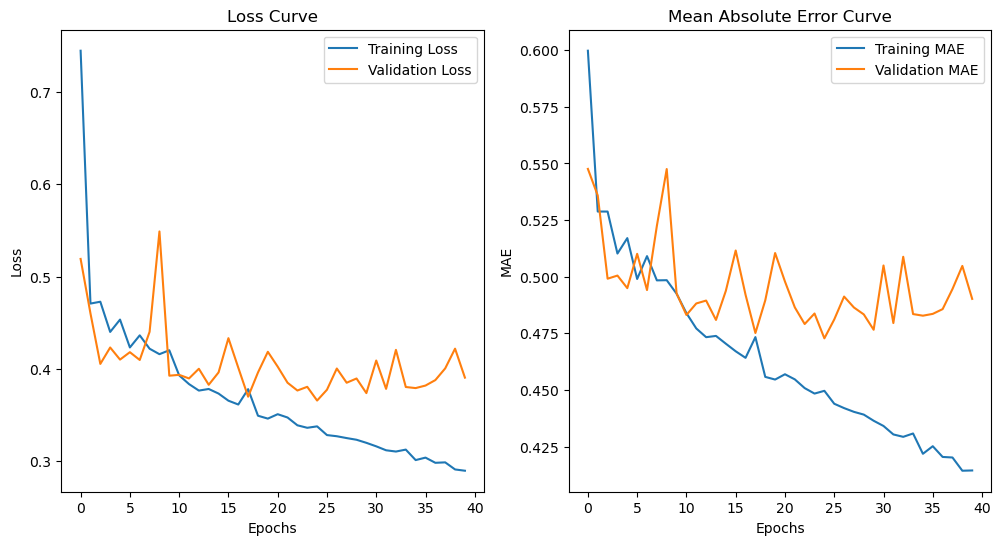

In [70]:
#Plotting graph for hybrid model
plt.figure(figsize=(12, 6))

#Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#MAE curve
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Mean Absolute Error Curve")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.show()


#### The model's training loss and validation loss curves show that the model is learning and generalizing well.
#### The training Mean Absolute Error (MAE) and validation MAE curves also indicate that the model is improving in terms of its ability to make accurate predictions.
#### There is a slight gap between the training and validation curves which might suggest that the model is slightly overfitting.

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


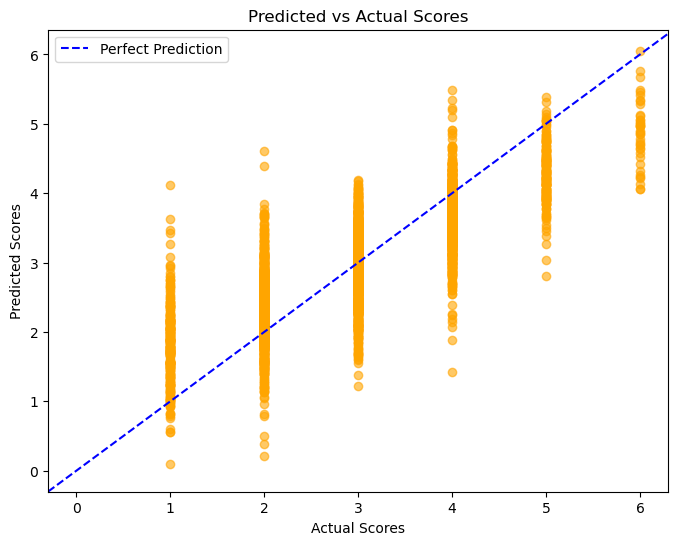

In [76]:
#Scatter plot of predicted vs actual scores
plt.figure(figsize=(8, 6))
plt.scatter(y_val, hybrid_model.predict([X_val_embeddings, X_val_features]), alpha=0.6, color='Orange')
plt.title("Predicted vs Actual Scores")
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.axline([0, 0], [1, 1], color='blue', linestyle='--', label="Perfect Prediction")  # 45-degree line
plt.legend()
plt.show()


##### This graph represents the comparison of the actual scores with the perfection of prediction.
##### Some predictions from the graph:
##### 1. The training essays are scored from 0 to 6 so are the predicted essays.
##### 2. ⁠The more densely populated datapoints are to the perfect prediction trend, the more accturate the predicted score will be.
##### 3. ⁠As per the graph the best predicted scores will be for the essays that are average scored (3-4)
##### 4. ⁠As per the graph intense scores (1,5,6 ) have comparatively more gaps with the predicted scores. Because of the lesser no. of training points present for these scores.

In [199]:
# Define a function to evaluate models
def evaluate_model(model, X_val_embeddings, X_val_features, y_val, model_name):
    #Prediction on the validation set
    predictions = model.predict([np.array(X_val_embeddings), np.array(X_val_features)])
    
    #Calculate metrics
    mae = mean_absolute_error(y_val, predictions)                #MAE
    rmse = np.sqrt(mean_squared_error(y_val, predictions))       #RMSE

    #Printing results
    print(f"Model: {model_name}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}\n")
    
    return mae, rmse

In [201]:
#generating sentence embeddings optimized for tasks like semantic similarity and paraphrase detection.
sentence_transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  
X_val_text = ["Replace this with your validation text data"] * len(X_val_features)  # Ensure consistent sample size

#precompute sentence embeddings for the validation text data
X_val_embeddings = sentence_transformer_model.encode(X_val_text)

In [202]:
#Ensuring embeddings and features are properly formatted (in numpy array)
X_val_embeddings = np.array(X_val_embeddings)  
X_val_features = np.array(X_val_features)     

In [205]:
#Placeholder variables for evaluation
#Dictionary for storing models with descriptive names
models = {
    "Hybrid Model": hybrid_model,       # Hybrid model combining embeddings and features
    "LSTM Model": rnn_model,           # LSTM using embedding as input
}

y_val = np.array(y_val)  # Ensure labels are numpy array

In [207]:
#evaluation metrics for each model
results = {}        #initializing an empty dictionary to store results
for model_name, model in models.items():
    #evaluating model on validation set
    mae, rmse = evaluate_model(model, X_val_embeddings, X_val_features, y_val, model_name)
    #storing the evaluation metrics in the results dictionary
    results[model_name] = {"MAE": mae, "RMSE": rmse}

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model: Hybrid Model
  Mean Absolute Error (MAE): 1.0871
  Root Mean Squared Error (RMSE): 1.3126

109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step
Model: LSTM Model
  Mean Absolute Error (MAE): 0.7909
  Root Mean Squared Error (RMSE): 1.0539



In [209]:
#Visualizing the results
mae_scores = [metrics["MAE"] for metrics in results.values()]
rmse_scores = [metrics["RMSE"] for metrics in results.values()]
model_names = list(results.keys())

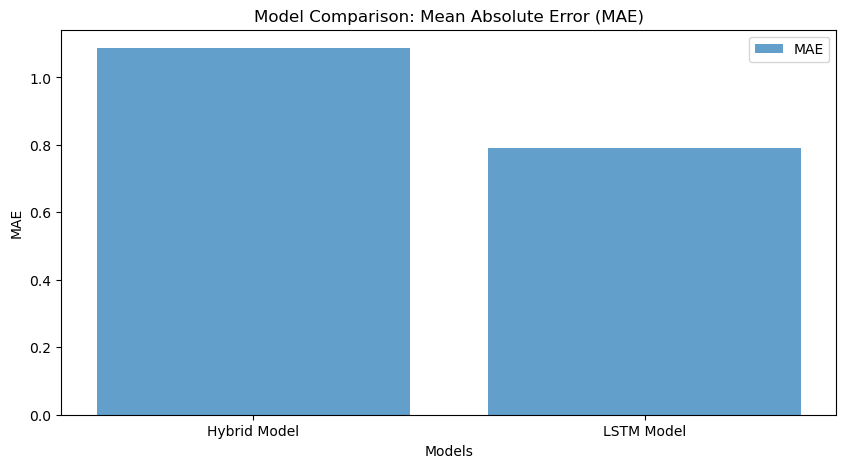

In [255]:
#Bar plot for MAE (Hybrid vs LSTM)
plt.figure(figsize=(10, 5))
plt.bar(model_names, mae_scores, alpha=0.7, label="MAE")
plt.title("Model Comparison: Mean Absolute Error (MAE)")
plt.ylabel("MAE")
plt.xlabel("Models")
plt.legend()
plt.show()

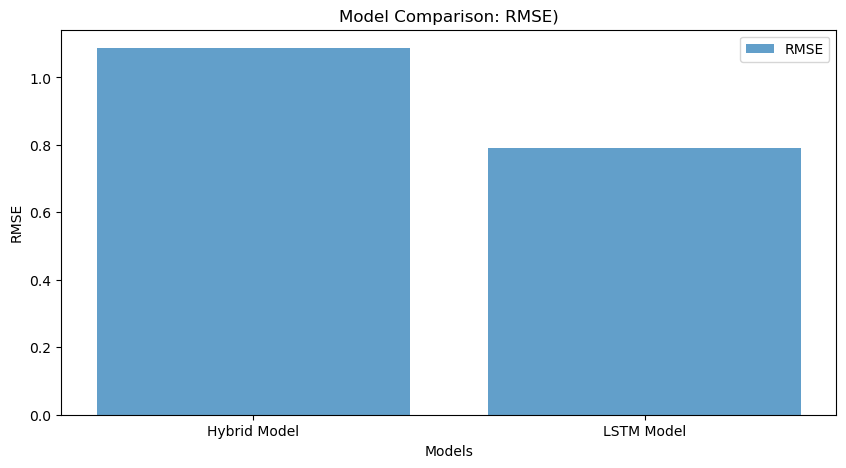

In [257]:
#Bar plot for RMSE (Hybrid vs LSTM)
plt.figure(figsize=(10, 5))
plt.bar(model_names, mae_scores, alpha=0.7, label="RMSE")
plt.title("Model Comparison: RMSE)")
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.legend()
plt.show()

### * LSTM may smooth out predictions, ignoring some of the outliers, leading to lower overall error but poorer prediction accuracy for nuanced cases.

### * The hybrid model may be more complex and have a higher capacity to learn nuanced relationships in the data.
### * Higher complexity might also mean more variability in predictions, which could lead to higher errors on specific samples.

In [251]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string

#defining a text cleaning function
def clean_text(text):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

    lemmatizer = WordNetLemmatizer()                 #lemmatization
    stop_words = set(stopwords.words('english'))     #stopword removal

    #converting to lowercase
    text = text.lower()
    #tokenize the text into words
    words = word_tokenize(text)
    #removing punctuation and stopwords
    words = [word for word in words if word.isalnum() and word not in stop_words]
    #Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

#defining a function for preprocessing new essays
def preprocess_essay(essay, embedding_model):
    from textstat import flesch_reading_ease

    #cleaning the essay
    cleaned_text = clean_text(essay)
    
    #extracting features
    num_sentences = len(sent_tokenize(essay))
    words = word_tokenize(essay)
    num_words = len(words)
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
    punctuation_density = sum(1 for char in essay if char in string.punctuation) / len(words) if num_words > 0 else 0
    vocab_richness = len(set(cleaned_text.split())) / len(cleaned_text.split()) if len(cleaned_text.split()) > 0 else 0
    readability = flesch_reading_ease(cleaned_text)

    #extract embeddings
    embedding = embedding_model.encode([cleaned_text])[0]

    #combining features into the correct format
    features = np.array([[num_sentences, avg_sentence_length, punctuation_density, vocab_richness, readability]])
    return embedding, features

#Scoring a new essay
new_essay = input("Enter your essay for scoring: ")

#Loading SentenceTransformer model for embeddings
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedding, features = preprocess_essay(new_essay, embedding_model)

#ensuring embeddings and features are properly formatted for the hybrid model
embedding = np.array([embedding])  #wrapping the embedding into a batch of size 1

#Predicting the score using the hybrid_model
predicted_score = hybrid_model.predict([embedding, features])
print(f"Predicted Score for your essay: {predicted_score[0][0]:.2f}")


Enter your essay for scoring:  The Importance of Education in Modern Society  Education is a cornerstone of modern society, serving as the foundation upon which progress and innovation are built. It is not merely a process of acquiring knowledge but an essential element for personal development, societal growth, and economic advancement. In today’s fast-evolving world, education plays an increasingly vital role, equipping individuals with the skills and knowledge they need to navigate life’s complexities and contribute meaningfully to their communities.  One of the primary functions of education is to foster critical thinking and problem-solving abilities. Through structured learning, students are exposed to diverse subjects, ideas, and perspectives that challenge their preconceived notions and encourage them to think independently. Whether solving mathematical equations, analyzing literature, or conducting scientific experiments, the educational process teaches individuals to approach

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul.RA01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Score for the new essay: 5.11


In [55]:
#Saving the hybrid model in the native Keras format
hybrid_model.save('hybrid_essay_scoring_model.keras')
print("Model saved successfully in Keras format!")

Model saved successfully in Keras format!


In [ ]:
# Save the SentenceTransformer model
embedding_model.save('embedding_model')
print("Embedding model saved successfully!")